## 3. Data format

Which analyses or experiments did you perform and what are the results? Choose suitable visualizations to show your results.

How do the results relate to your hypotheses?

Did you find interesting or unexpected things? How do they influence your project?

What are problems that you encountered? How could you plan to deal with them?


Do the analyses and results make sense? How can they be interpreted?

What are the next steps in the project?

Which aspects of your findings do you want to put in the center?

Which ones do you decide not to pursue further?

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [192]:
# load sample data
sample_dir = 'data/anglophone/'

gangsta_files = ['50Cent_CandyShop.rap',
'50Cent_DiscoInferno.rap',
'50Cent_InDaClub.rap',
'50Cent_JustALilBit.rap',
'50Cent_P.I.M.P..rap',
'Eminem_TheWayIAm.rap',
'JayZ_CanIGetA.rap',
'JayZ_HolyGrail.rap',
'JayZ_NiggasInParis.rap',
'KanyeWest_Clique.rap',
'KanyeWest_Mercy.rap',
'LilWayne_AMilli.rap',
'LilWayne_GotMoney.rap',
'LilWayne_Lollipop.rap',
'Ludacris_HowLow.rap',
'Ludacris_MoveBitch.rap',
'Ludacris_StandUp.rap',
'Ludacris_WhatsYourFantasy.rap',
'Mims_ThisIsWhyImHot.rap',
'MissyElliott_WorkIt.rap',
'Nelly_Grillz.rap',
'SnoopDogg_LayLow.rap',
'SnoopDogg_Woof.rap',
'T.I._LiveYourLife.rap',
'T.I._WhatYouKnow.rap',
'TerrorSquad_LeanBack.rap']

oldschool_files=[
'2pac_CaliforniaLove.rap',
'2pac_HowDoUWantIt.rap',
'2pac_IGetAround.rap',
'2pac_PapazSong.rap',
'2pac_SoManyTears.txt',
'DrDre_NuthinButAGThang.rap',
'Eminem_RockBottom.rap',
'Eminem_TheRealSlimShady.rap',
'JayZ_CantKnockTheHustle.rap',
'KrisKross_Jump.rap',
'LLCoolJ_HeyLover.rap',
'LLCoolJ_INeedLove.rap',
'NotoriousBIG_BigPoppa.rap',
'NotoriousBIG_GoingBackToCali.rap',
'NotoriousBIG_Hypnotize.rap',
'NotoriousBIG_Juicy.rap',
'NotoriousBIG_MoMoneyMoProblems.rap',
'NotoriousBIG_OneMoreChance.rap',
'NotoriousBIG_SkysTheLimit.rap',
'Run-D.M.C._DownWithTheKing.rap',
'SnoopDogg_GinAndJuice.rap',
'WarrenG_Regulate.rap',
'WillSmith_GettinJiggyWitIt.rap',
'WillSmith_Summertime.rap',
'WillSmith_WildWildWest.rap',
'Wreckx-N-Effect_RumpShaker.rap',
]

In [589]:
def _convert_recip(string, ref):
    if '=' in string:
        return string
    else:    
        dots = string.count('.')
        num = int(string.strip('.'))
        coef = 1
        for d in range(dots):
            coef += 1 / (2**(d+1))

        return coef * ref / num
        

class HumdrumSummary():
    def __init__(self, sample_path):
        raw_df =  pd.read_table(sample_path)
        df = raw_df[raw_df['**recip'].apply(lambda x: '!' not in x)]   
        
        tempo = int(df['**recip'][df['**recip'].apply(lambda x: '*MM' in x)].unique()[0].strip('*MM')) 
        meter = tuple(map(lambda x: int(x), \
                         df['**recip'][df['**recip'].apply(lambda x: '/' in x)].unique()[0].strip('*M').split('/')))
        
    
        df = df[df['**recip'].apply(lambda x: x[0] in '0123456789=')]
        df['**recip'] = df['**recip'].apply(lambda x: _convert_recip(string=x,ref=meter[1]))             
        
        pickup = False
        
        if (df['**recip'] == '=0').any():
            pickup = True
            pickup_start = df[df['**recip'].apply(lambda x: x == '=0')].index
            pickup_end = df[df['**recip'].apply(lambda x: x == '=1')].index

            for i, idx in enumerate(pickup_start):
                snippet = df.loc[idx+1:pickup_end[i]-1]
                snippet['**recip'][snippet['**lyrics']=='.'] = 0
                rest = meter[0] - snippet['**recip'][snippet['**lyrics']!='.'].sum()
                snippet['**recip'].at[idx+1] = rest
        
        df = df[df['**recip'].apply(lambda x: type(x) != str)]
        df = df[df['**recip'] != 0]
        df['cum_recip'] = df['**recip'].cumsum()
        df['breakpoints'] = df['cum_recip'][df['**break'].apply(lambda x: x in ['3','4'])].apply(lambda x: np.floor((x-df['**recip'].min()/4)%4))
        
        self.pickup = pickup
        self.measure = df['**recip'].sum() / meter[0]
        self.meter = meter
        self.tempo = tempo
        self.df = df
        self.raw_df = raw_df
        self.clean_df = df[df['**recip'].apply(lambda x: type(x) == float)]        
        self.syl_onsets = df[df['**lyrics']!='.'].shape[0]
        self.syllabic_rate = 60 / (tempo * df['**recip'][df['**lyrics']!='.'].mean()) # or total number of measures, divided by..         
        self.rhyme = df[df['**rhyme']!='.'].cum_recip.apply(lambda x: (x-df['**recip'].min()/4)%4)
        self.MC = sample_path.split('/')[-1].split('_')[0]
        self.breakpoints = df['breakpoints']


        
        
    
    def phrase_based(self, clean_rest=False):
        # according to the description on the website and our common knowledge of interpreting the lyrics,
        # we concluded that only level 3,4 break are meaningful.
        sample_clean = self.df
        if clean_rest:
            sample_clean = sample_clean[sample_clean['**lyrics']!='.']

        breaks_idx = sample_clean[sample_clean['**break'].apply(lambda x: x in ['3','4'])].index
        # add closing break point

        # create a new dataframe that will show the flowwise analysis on this song
        sample_flowwise = pd.DataFrame(columns=['recip','lyric'])


        for i in range(breaks_idx.shape[0]-1):
            (start, end) = (breaks_idx[i], breaks_idx[i+1])
            snippet = sample_clean.loc[start:end-1]
            sample_flowwise.at[i,'recip'] = snippet['**recip'].values
            sample_flowwise.at[i,'lyric'] = ' '.join(snippet['**lyrics'].values)

        maxlen = sample_flowwise.lyric.apply(lambda x: len(x)).max()
        pd.set_option('display.max_colwidth', maxlen)
        return sample_flowwise
    
        
def flowwise_visualize(flowwise_df):
    sample = flowwise_df
    maxlen = sample.recip.apply(lambda x: len(x)).max()
    sample.recip = sample.recip.apply(lambda x: np.concatenate([x, [0]* (maxlen - len(x))]))
    s = pd.DataFrame(item for item in sample.recip)

    viz = s.plot(kind='bar', stacked=True, legend=None)
    plt.xticks([])
    return viz
    
    

/Users/haeeunkim/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


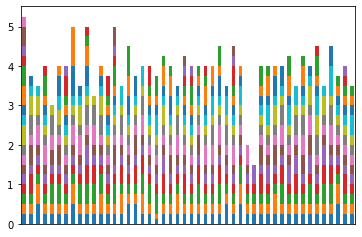

In [618]:
sample_path
sample = HumdrumSummary(sample_path)
flowwise_visualize(sample.phrase_based())

#df['**recip'].sum()/4

In [613]:
oldschool_error = []
summary = {'title' :[], 'MC':[],'tempo':[],'meter':[], 'syl_onsets':[], 'syllabic_rate':[], \
           'rhyme':[], 'genre':[], 'syl_onset_mean':[], 'measure':[], 'breakpoints':[]}
for i, f in enumerate(oldschool_files):
    try:
        sample_path = sample_dir + 'Old School/' + f
        sample = HumdrumSummary(sample_path)
#        pos = sample.rhyme_postion_dist()
        summary['tempo'].append(sample.tempo)
        summary['meter'].append(sample.meter)
        summary['syl_onsets'].append(sample.syl_onsets)
        summary['syllabic_rate'].append(sample.syllabic_rate)
        summary['rhyme'].append(sample.rhyme)
        summary['title'].append(f)
        summary['MC'].append(sample.MC)
        summary['genre'].append('oldschool')
        summary['measure'].append(sample.measure)
        summary['syl_onset_mean'].append(sample.df['**recip'][sample.df['**lyrics']!='.'].mean())
        summary['breakpoints'].append(sample.breakpoints.dropna())

        
    except:
        oldschool_error.append(sample_path)
        pass
    
gangsta_error = []

for i, f in enumerate(gangsta_files):
    try:
        sample_path = sample_dir + 'Gangsta/' + f
        sample = HumdrumSummary(sample_path)
        df = sample.df
        summary['tempo'].append(sample.tempo)
        summary['meter'].append(sample.meter)
        summary['syl_onsets'].append(sample.syl_onsets)
        summary['syllabic_rate'].append(sample.syllabic_rate)
        summary['rhyme'].append(sample.rhyme)
        summary['title'].append(f)
        summary['MC'].append(sample.MC)
        summary['genre'].append('gangsta')
        summary['measure'].append(sample.measure)
        summary['syl_onset_mean'].append(sample.df['**recip'][sample.df['**lyrics']!='.'].mean())
        summary['breakpoints'].append(sample.breakpoints.dropna())
        
    
    except:
        gangsta_error.append(sample_path)
        pass
print(len(gangsta_error), len(oldschool_error))

/Users/haeeunkim/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/Users/haeeunkim/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


5 6


In [615]:
summary_df = pd.DataFrame(summary)

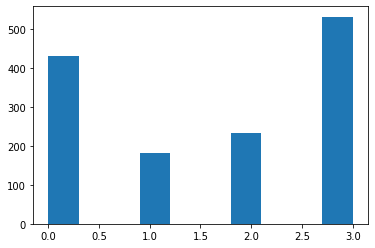

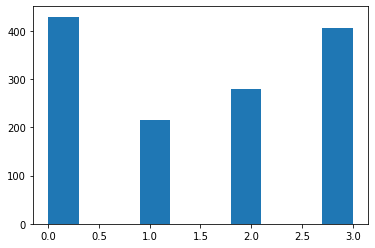

In [616]:
# metriacal position of start of new phrases

plt.hist(pd.concat(list(summary_df['breakpoints'][summary_df.genre=='oldschool'])))
plt.show()
plt.hist(pd.concat(list(summary_df['breakpoints'][summary_df.genre=='gangsta'])))
plt.show()

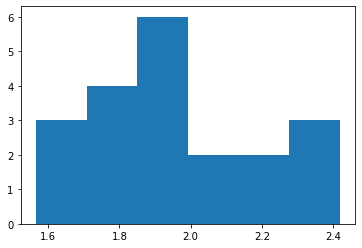

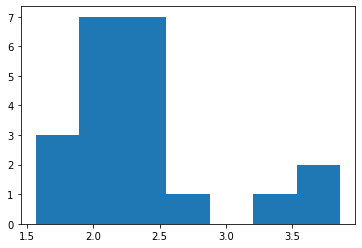

In [610]:
# syllabic rate - syllables per second
plt.hist(summary_df['syllabic_rate'][summary_df.genre == 'oldschool'], bins='auto')
plt.show()

plt.hist(summary_df['syllabic_rate'][summary_df.genre == 'gangsta'],bins='auto')
plt.show()

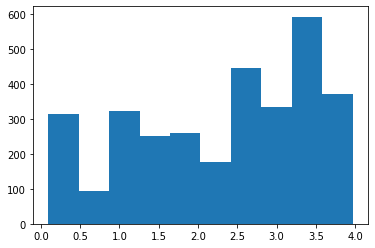

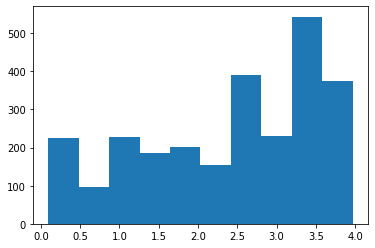

In [617]:
# metrical position of rhymed syllables

plt.hist(pd.concat(list(summary_df['rhyme'][summary_df.genre=='oldschool'])))
plt.show()
plt.hist(pd.concat(list(summary_df['rhyme'][summary_df.genre=='gangsta'])))
plt.show()